In [28]:
import tensorflow as tf
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import islice
from IPython import display


def show_dataset_examples(ds):
  grid = ImageGrid(plt.figure(), 111, nrows_ncols=(4, 4), axes_pad = 0.1)
  for index, img in islice(enumerate(ds),16):
    grid[index].imshow((img+1)/2, cmap = 'Greys')
  plt.show()


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

def train(dataset, epochs):

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def scale_and_show(img):
  plt.imshow(np.array(img[:,:,0]), cmap = "Greys")

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      scale_and_show(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

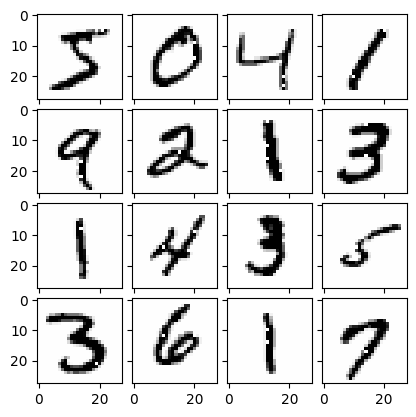

(60000, 28, 28)


In [29]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
show_dataset_examples(train_images)
print (train_images.shape) # 60,000 images with height and width both being 28

In [30]:
print (train_images.shape)
train_images_reshaped = np.expand_dims(train_images, 3)
print (train_images_reshaped.shape) # 28 x 28 with 1 color channel(grayscale image)

(60000, 28, 28)
(60000, 28, 28, 1)


In [31]:
print (train_images_reshaped.min(), train_images_reshaped.max())
train_images_scaled = (train_images_reshaped - 127.5)/127.5
print (train_images_scaled.min(), train_images_scaled.max())

0 255
-1.0 1.0


In [32]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_SIZE = 28
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
generator_lr = .0001
discriminator_lr = .0001

In [33]:
# discriminator model
def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))

    model.add(layers.LeakyReLU()) # y = x for x positive(for x negative, small + slope)
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))


    return model

In [34]:
discriminator = make_discriminator_model()
print (discriminator.summary())

decision = discriminator.predict(train_images_scaled[:1])
print()
print ("Prediction for image from training data:", decision)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [35]:
# generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization()) # avoid overfitting
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256))) # preserves
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

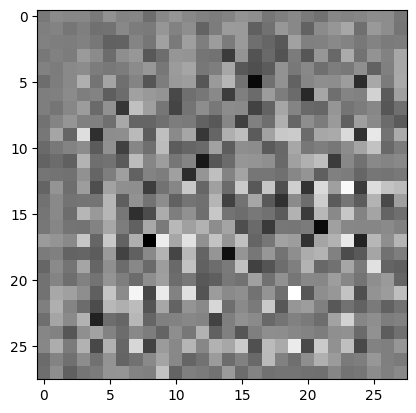

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)        

In [36]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

scale_and_show(generated_image[0])
plt.show()

print(generator.summary())

In [37]:
# Tingkat Pembelajaran
generator_lr = 0.0002
discriminator_lr = 0.0002

In [38]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # low - similar; high - very different

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [40]:
def generator_loss(disc_fake_output):
    loss = cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output) # low loss if discriminator predicts 1 for a fake image(not doing what it's supposed to do)
    return loss

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(generator_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_lr)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [42]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # pass noise to force it to learn(like dropout)

      #Get the discriminator's output:
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #Calculate each network's loss:
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    #Update each network's weights to (hopefully) reduce the loss next time:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


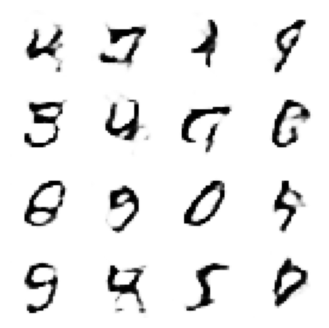

In [43]:
train(train_dataset, EPOCHS)

<ipython-input-47-71d2d8036e22>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


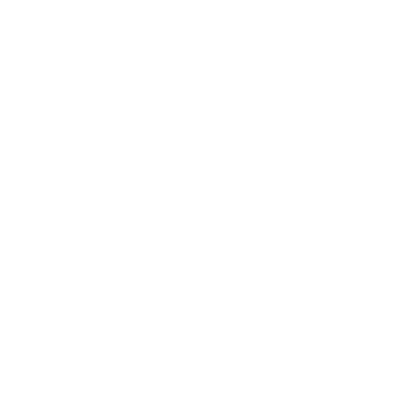

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
anim_file = 'dcgan.gif'

# Ambil daftar nama file gambar
filenames = sorted(glob.glob('image*.png'))

# Set durasi frame ke 0.5 detik
durations = [0.5] * len(filenames)

# Buat animasi GIF dan set durasi menggunakan imageio
with imageio.get_writer(anim_file, duration=durations, mode='I') as writer:
    for i, filename in enumerate(filenames):
        image = imageio.imread(filename)

        # Efek fade: kombinasikan gambar dengan warna latar belakang hitam
        fade_factor = i / len(filenames)
        fade_image = (1 - fade_factor) * 255 + fade_factor * image
        fade_image = fade_image.astype(np.uint8)

        writer.append_data(fade_image)

# Tampilkan animasi GIF
from IPython.display import display, Image
display(Image(filename=anim_file))

# Download animasi GIF
try:
    from google.colab import files
    files.download(anim_file)
except ImportError:
    pass
else:
    files.download(anim_file)